In [1]:
import logging

import matplotlib
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# -------------------------------------------- #
# Constants                                    #
# -------------------------------------------- #
YEARS_IN_HIST_BIN = 15
DATA_FILE_PATH = '../public/data/data.csv'
CITIES_FILE_PATH = '../public/data/cities.csv'

In [2]:
# -------------------------------------------- #
# Normalization Functions                      #
# -------------------------------------------- #
def normalize_year(year: str) -> int:
    if year == 'n.d.':
        return 0
    try:
        return int(year.split('-')[0])
    except:
        logging.warning(f'Could not parse year: {year}')
        return 0


def normalize_language(lang: str):
    if 'latin' in lang.lower():
        return 'Latin'
    return lang

def normalize_city(city: str):
    if '/' in city:
        return city.split('/')[0]
    if ' and ' in city:
        return city.split(' and ')[0]
    return city


def format_numbers(val):
    if np.isnan(val):
        return val
    return int(val) if val == int(val) else round(val, 2)

# -------------------------------------------- #
# Helper Functions                             #
# -------------------------------------------- #
def count_table(column):
    return df[column].value_counts().sort_values(ascending=False)


In [3]:
logging.info("Loading data and applying normalization")

# Load data
df = pd.read_csv(DATA_FILE_PATH)
df['city'] = df['city'].apply(normalize_city)
cities_df = pd.read_csv(CITIES_FILE_PATH)
df = pd.merge(df, cities_df, on='city', how='left')

# Loop through all columns whose names start with 'country_in_' and fill NA values
cols_to_fill = df.filter(like='country_in_').columns
for col in cols_to_fill:
    df[col] = df[col].fillna('n.p.')

# Apply normalization
df['normalized_year'] = df['year'].apply(normalize_year)
df['normalized_year'] = pd.to_numeric(df['normalized_year']) # , errors='coerce'
df['normalized_language'] = df['language'].apply(normalize_language)

# Filter out editions with no year
df = df[df['normalized_year'] != 0]
logging.info(f"Filtered out the following editions with no year:\n{df[df['normalized_year'] == 0]}")

# Round years to nearest multiple of bin size
df['rounded_year'] = np.round(df['normalized_year'] / YEARS_IN_HIST_BIN) * YEARS_IN_HIST_BIN
min_year = df['normalized_year'].min()
max_year = df['normalized_year'].max()

In [4]:
# -------------------------------------------- #
# Visualization Functions                      #
# -------------------------------------------- #
def create_histogram(column_name, display_name, limit=None):
    # Get the frequencies
    column_count_table = count_table(column_name)

    # Apply the limit
    if limit is not None:
        column_count_table = column_count_table.head(limit)

    # Prepare a color map
    num_languages = len(column_count_table)
    cmap = plt.cm.get_cmap('tab20', num_languages)

    # Create histogram
    plt.figure(figsize=(10, 6))

    for idx, column in enumerate(column_count_table.index):
        subset = df[df[column_name] == column]
        label = f"{column} (Total: {column_count_table[column]})"
        plt.hist(subset['rounded_year'], bins=np.arange(min(df['rounded_year']), max(df['rounded_year']) + YEARS_IN_HIST_BIN, YEARS_IN_HIST_BIN), alpha=0.5, label=label, color=cmap(idx))

    plt.xlim(min_year - 10, max_year + 10)
    if limit is not None:
        plt.title(f'Histogram of Years by top {limit} {display_name}')
    else:
        plt.title(f'Histogram of Years by {display_name}')
    plt.xlabel('Year')
    plt.ylabel('Number of Editions')
    plt.legend(title=display_name)
    plt.show()


def create_box_plot(column_name, display_name, limit=None):
    # Get the frequencies
    column_count_table = count_table(column_name)

    # Apply the limit
    if limit is not None:
        column_count_table = column_count_table.head(limit)

    # Create box plot
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=column_name, y='normalized_year', data=df, order=column_count_table.index)
    if limit is not None:
        plt.title(f'Box Plot of Years by top {limit} {display_name}')
    else:
        plt.title(f'Box Plot of Years by {display_name}')
    plt.xlabel(display_name)
    plt.xticks(rotation=45)
    plt.ylabel('Year')
    plt.show()



def create_stat_table(column_names: str | list[str], display_names: str | list[str]):
    # Group data by column_names and describe statistics for 'normalized_year'
    stat_table = df.groupby(column_names)['normalized_year'].describe(percentiles=[.25, .5, .75])

    # Only keep the statistics we're interested in
    stat_table = stat_table[['count', 'min', 'max', 'mean']] # , '25%', '50%', '75%'

    # Sort the table based on the frequency of each language, to match the order in the boxplot
    stat_table = stat_table.loc[count_table(column_names).index]

    # Rename the index to be the display_name
    stat_table.index.names = [display_names] if isinstance(display_names, str) else display_names

    # Apply the formatting function to the entire DataFrame
    formatted_stat_table = stat_table.applymap(format_numbers)
    print(formatted_stat_table)
    return formatted_stat_table

def create_mini_histograms(column_name, limit=None):
    if limit is None:
        limit = 6
    elif limit % 3 != 0:
        limit = limit + (3 - limit % 3)
    # Get the top `limit` most frequent languages
    top_languages = count_table(column_name).index[:limit]

    # Filter the DataFrame to only include these top languages
    df_top = df[df[column_name].isin(top_languages)]

    # Initialize the FacetGrid, using the order for top languages
    g = sns.FacetGrid(df_top, col=column_name, col_order=top_languages, col_wrap=3)
    g.map(sns.histplot, "normalized_year", bins=np.arange(min(df['rounded_year']), max(df['rounded_year']) + YEARS_IN_HIST_BIN, YEARS_IN_HIST_BIN))

    # Add titles and labels
    g.set_axis_labels("Year", "Editions")
    g.set_titles("{col_name}")
    plt.xlim(min_year - 10, max_year + 10)
    plt.show()

def create_full_visualization(column_name, display_name, limit=None):
    create_histogram(column_name, display_name, limit)
    create_box_plot(column_name, display_name, limit)
    create_stat_table(column_name, display_name)
    create_mini_histograms(column_name, limit)

# Analysis by Language

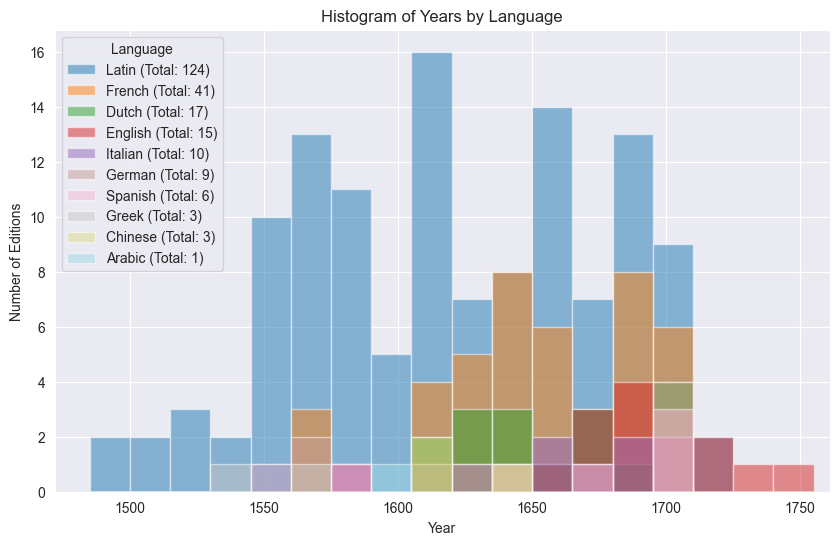

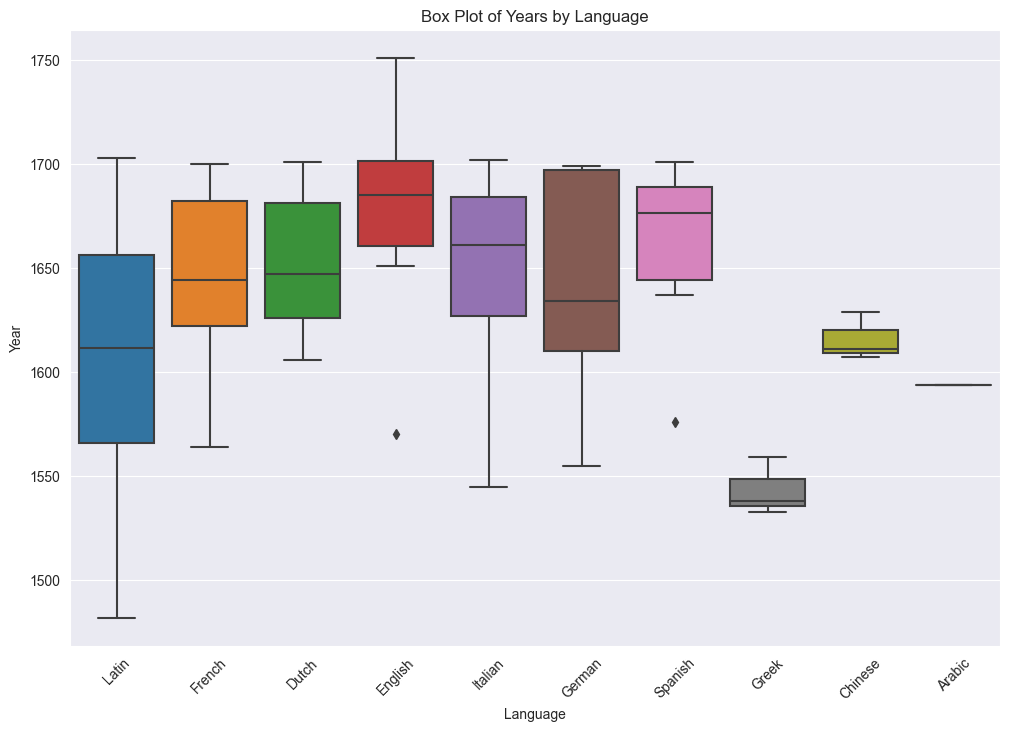

          count   min   max     mean
Language                            
Latin       124  1482  1703  1612.41
French       41  1564  1700  1644.73
Dutch        17  1606  1701  1651.35
English      15  1570  1751  1681.67
Italian      10  1545  1702  1646.90
German        9  1555  1699  1640.89
Spanish       6  1576  1701  1659.33
Greek         3  1533  1559  1543.33
Chinese       3  1607  1629  1615.67
Arabic        1  1594  1594  1594.00


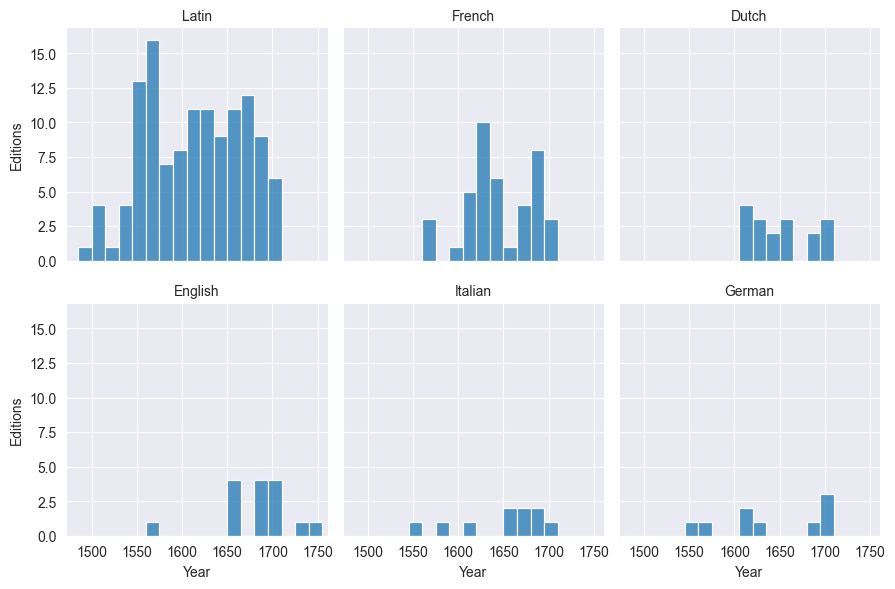

In [5]:
create_full_visualization('normalized_language', 'Language')

# Analysis by City

In [6]:
city_tbl = create_stat_table(['city', 'country_in_1600', 'country_in_2000'], ['City', 'Country in 1600', 'Country in 2000'])

                                                   count   min   max     mean
City       Country in 1600        Country in 2000                            
Paris      Kingdom of France      France              53  1516  1697  1615.09
London     England                United Kingdom      19  1570  1751  1674.89
Amsterdam  Dutch Republic         Netherlands         13  1616  1701  1669.31
Venice     Republic of Venice     Italy               12  1482  1647  1559.75
Strasbourg Holy Roman Empire      France              11  1538  1599  1566.91
Cologne    Holy Roman Empire      Germany             10  1556  1627  1592.60
Rome       Papal States           Italy                8  1545  1655  1591.75
Lyon       Kingdom of France      France               8  1557  1690  1652.38
Leiden     Dutch Republic         Netherlands          6  1606  1692  1647.67
Antwerp    Habsburg Netherlands   Belgium              5  1645  1683  1663.80
Rouen      Kingdom of France      France               5  1649  

# Analysis by "Country" in 1600

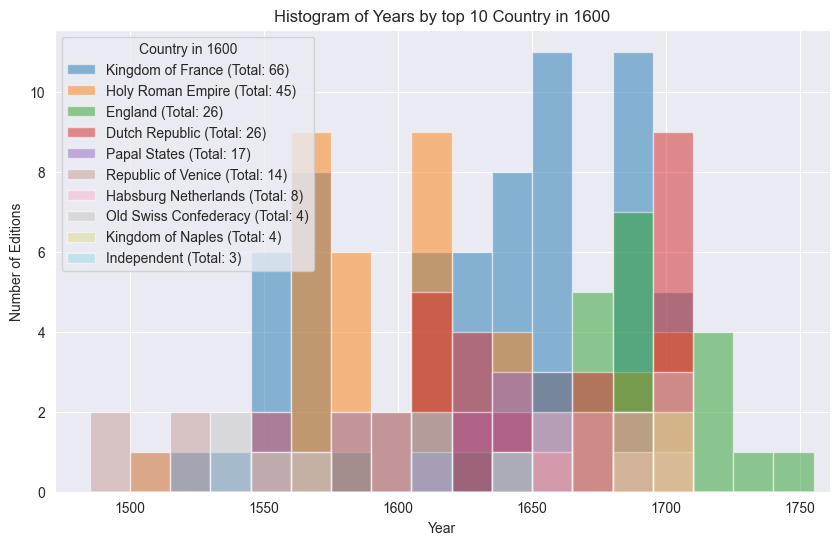

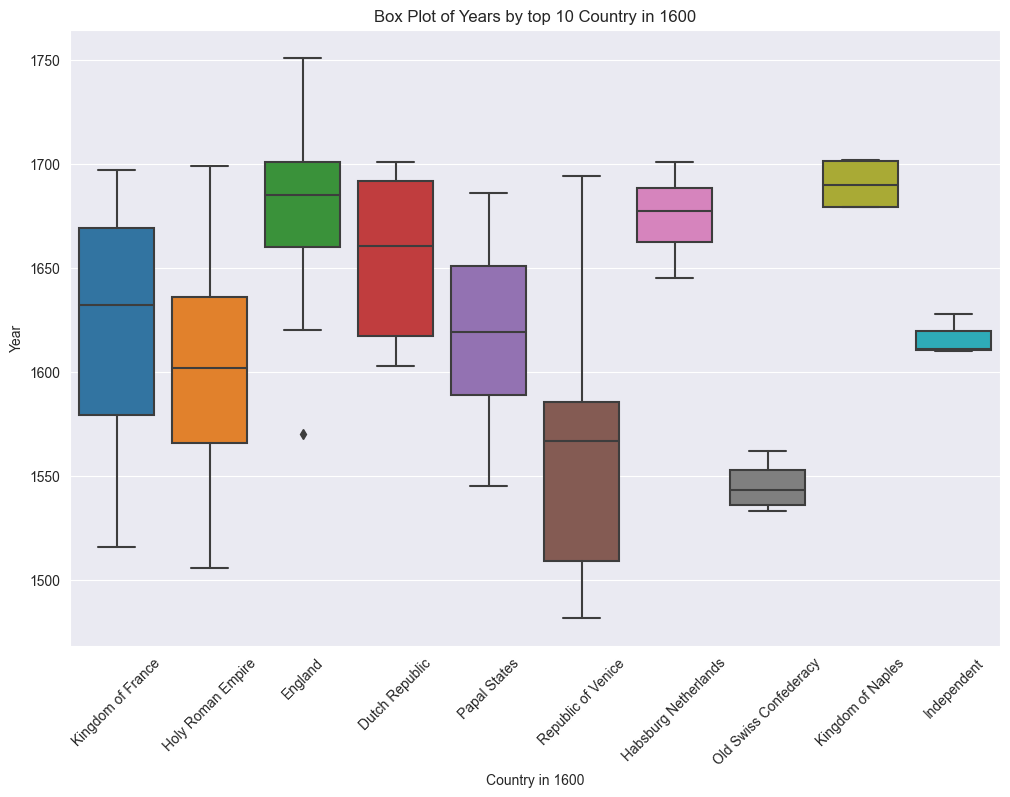

                        count   min   max     mean
Country in 1600                                   
Kingdom of France          66  1516  1697  1624.08
Holy Roman Empire          45  1506  1699  1606.67
England                    26  1570  1751  1678.27
Dutch Republic             26  1603  1701  1654.65
Papal States               17  1545  1686  1616.06
Republic of Venice         14  1482  1694  1564.43
Habsburg Netherlands        8  1645  1701  1674.62
Old Swiss Confederacy       4  1533  1562  1545.50
Kingdom of Naples           4  1679  1702  1690.25
Independent                 3  1610  1628  1616.33
Ming Dynasty                3  1607  1629  1615.67
Spanish Netherlands         3  1620  1633  1626.00
Spain                       3  1576  1665  1626.00
Duchy of Milan              2  1671  1702  1686.50
n.p.                        1  1650  1650  1650.00
Republic of Genoa           1  1644  1644  1644.00
Duchy of Urbino             1  1575  1575  1575.00
Grand Duchy of Tuscany      1  

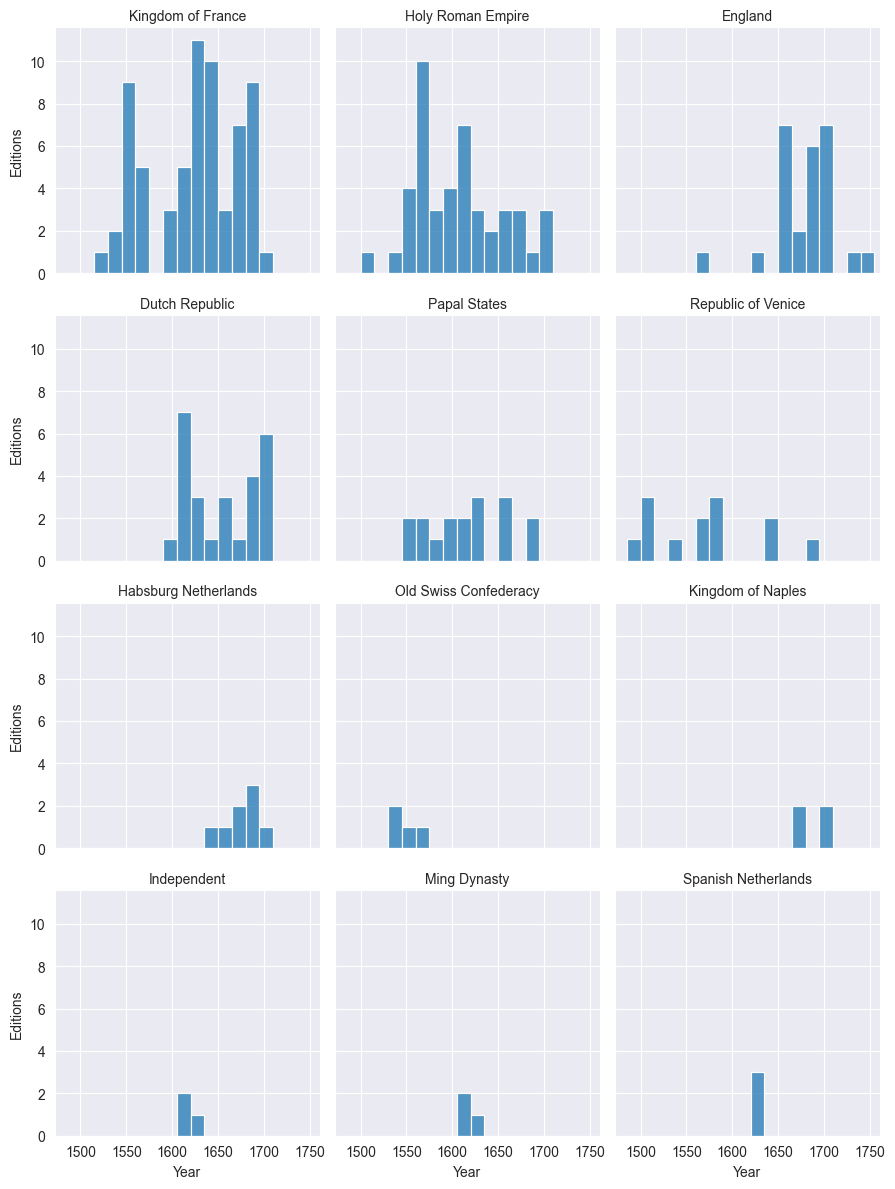

In [7]:
create_full_visualization('country_in_1600', 'Country in 1600', limit=10)